# Optim Bottom-Up

## Setup


In [ ]:
%load_ext autoreload
%autoreload 2
from importlib import reload
import logging
reload(logging)

import torch
import matplotlib.pyplot as plt
from pprint import pprint

import tensorcraft as tc

log = logging.getLogger("tensorcraft")
log.setLevel(logging.INFO)

05-03-2025 04:43:52 : INFO : compiler : __init__ -- Grammar file loaded successfully.
05-03-2025 04:43:52 : INFO : compiler : __init__ -- Parser object created successfully.


## Redistributors

Given a tensor shape, a starting distribution and a target distribution, creates a sequence of collective ops to reach the target dist while optimizing for different metrics.

### Naive Gather Split

Simplest redistributor. Just allgathers, then splits. Should be both communication and memory ineficient. 

In [ ]:
naive_rdist = tc.optim.NaiveGathererRedist(tc.optim.IdealLowerBoundsCM())

D_[2,4]⊥{(1,0),∅}-(1,∅)


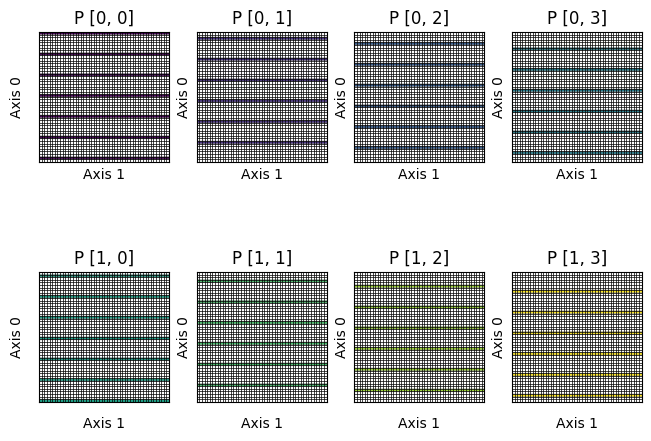

In [ ]:
tensor_shape = torch.Size((50,50))
mesh = torch.Size((2,4))
dist = tc.dist.MultiAxisDist(mesh, ((1,0), ()), (1, 1))
print(dist)
fig = plt.figure(layout='constrained')
tc.viz.draw_processor_grid(fig, tensor_shape, dist)


In [ ]:
target_dist = tc.dist.MultiAxisDist(mesh, ((), (0,)), (10, 10))
sequence, cost = naive_rdist.redistribute(tensor_shape, dist, target_dist)
pprint(sequence)
print(cost)

05-03-2025 04:44:01 : INFO : naive_gatherer : redistribute -- Dist D_[2,4]⊥{∅,∅}-(∅,∅), volume: 350.0, n_procs 8
[(None,
  D_[2,4]⊥{(1,0),∅}-(1,∅),
  Cost(latency=0, bandwidth=0, computation=0, max_memory_delta=0)),
 ('allgather_*',
  D_[2,4]⊥{∅,∅}-(∅,∅),
  Cost(latency=3, bandwidth=2450.0, computation=0, max_memory_delta=2150.0)),
 ('split_*',
  D_[2,4]⊥{∅,0}-(∅,10),
  Cost(latency=0, bandwidth=0, computation=0, max_memory_delta=-1000.0))]
Cost(latency=3, bandwidth=2450.0, computation=0, max_memory_delta=2150.0)


In [ ]:
tensor_shape = torch.Size([50, 50])
mesh = torch.Size([2, 4])
dist = tc.dist.MultiAxisDist(mesh, ((0,), ()), 2) 
target_dist = tc.dist.MultiAxisDist(mesh, ((), (0,)), 2)
mem_constrained_dist = tc.optim.MemoryConstrainedRedist(tc.optim.IdealLowerBoundsCM())
print(dist)
print(target_dist)
sequence, cost = mem_constrained_dist.redistribute(tensor_shape, dist, target_dist)
pprint(sequence)
pprint(cost)
print(dist)
print(target_dist)

D_[2,4]⊥{0,∅}-(2,∅)
D_[2,4]⊥{∅,0}-(∅,2)
05-03-2025 04:44:01 : INFO : mem_const : _redistribute_multi_axis -- D_[2,4]⊥{0,∅}-(2,∅)
05-03-2025 04:44:01 : INFO : mem_const : _redistribute_multi_axis -- D_[2,4]⊥{∅,0}-(∅,2)
Cost: 1301.0------------------------
[(None,
  D_[2,4]⊥{0,∅}-(2,∅),
  Cost(latency=0, bandwidth=0, computation=0, max_memory_delta=0)),
 ('alltoall_0_1_-1',
  D_[2,4]⊥{∅,0}-(∅,2),
  Cost(latency=1, bandwidth=1300.0, computation=0, max_memory_delta=0))]
Cost: 4005.0------------------------
[(None,
  D_[2,4]⊥{0,∅}-(2,∅),
  Cost(latency=0, bandwidth=0, computation=0, max_memory_delta=0)),
 ('split_0_1_1',
  D_[2,4]⊥{(1,0),∅}-(2,∅),
  Cost(latency=0, bandwidth=0, computation=0, max_memory_delta=-900.0)),
 ('alltoall_0_1_-1',
  D_[2,4]⊥{∅,(1,0)}-(∅,2),
  Cost(latency=3, bandwidth=2800.0, computation=0, max_memory_delta=0)),
 ('allgather_1',
  D_[2,4]⊥{∅,0}-(∅,2),
  Cost(latency=2, bandwidth=1200.0, computation=0, max_memory_delta=0))]
Cost: 1651.0------------------------
[(Non

In [ ]:
tensor_shape = torch.Size([8, 8, 8, 4])
mesh = torch.Size([4,2,4])
dist = tc.dist.MultiAxisDist(mesh, ((0,1), (), (), ()), 1) 
target_dist = tc.dist.MultiAxisDist(mesh, ((), (1,), (0,), ()), (-1, 4, 2, -1))
mem_constrained_dist = tc.optim.MemoryConstrainedRedist(tc.optim.IdealLowerBoundsCM())
print(dist)
print(target_dist)
sequence, cost = mem_constrained_dist.redistribute(tensor_shape, dist, target_dist)
pprint(sequence)
pprint(cost)
print(dist)
print(target_dist)

D_[4,2,4]⊥{(0,1),∅,∅,∅}-(1,∅,∅,∅)
D_[4,2,4]⊥{∅,1,0,∅}-(∅,4,2,∅)
05-03-2025 05:00:56 : INFO : mem_const : _redistribute_multi_axis -- D_[4,2,4]⊥{(0,1),∅,∅,∅}-(1,∅,∅,∅)
05-03-2025 05:00:56 : INFO : mem_const : _redistribute_multi_axis -- D_[4,2,4]⊥{∅,1,0,∅}-(∅,4,2,∅)


Cost: 1027.0------------------------
[(None,
  D_[4,2,4]⊥{(0,1),∅,∅,∅}-(1,∅,∅,∅),
  Cost(latency=0, bandwidth=0, computation=0, max_memory_delta=0)),
 ('alltoall_minor_0_1_4',
  D_[4,2,4]⊥{0,1,∅,∅}-(2,4,∅,∅),
  Cost(latency=1, bandwidth=256.0, computation=0, max_memory_delta=0)),
 ('alltoall_0_2_-1',
  D_[4,2,4]⊥{∅,1,0,∅}-(∅,4,2,∅),
  Cost(latency=2, bandwidth=768.0, computation=0, max_memory_delta=0))]
Cost: 1027.0------------------------
[(None,
  D_[4,2,4]⊥{(0,1),∅,∅,∅}-(1,∅,∅,∅),
  Cost(latency=0, bandwidth=0, computation=0, max_memory_delta=0)),
 ('alltoall_minor_0_1_4',
  D_[4,2,4]⊥{0,1,∅,∅}-(2,4,∅,∅),
  Cost(latency=1, bandwidth=256.0, computation=0, max_memory_delta=0)),
 ('alltoall_0_2_2',
  D_[4,2,4]⊥{∅,1,0,∅}-(∅,4,2,∅),
  Cost(latency=2, bandwidth=768.0, computation=0, max_memory_delta=0))]
Cost: 2052.0------------------------
[(None,
  D_[4,2,4]⊥{(0,1),∅,∅,∅}-(1,∅,∅,∅),
  Cost(latency=0, bandwidth=0, computation=0, max_memory_delta=0)),
 ('alltoall_0_2_-1',
  D_[4,2,4]⊥{∅,∅